# Regression models of NBA rookie player statistics

The data set (`nba.csv`) is a record of statistics of several rookie NBA players throughout their first season.

```python
|    | name            |   games_played |   minutes_played |   points_scored |... |   5yrs |
|---:|:----------------|---------------:|-----------------:|----------------:|...:|-------:|
|  0 | Brandon Ingram  |             36 |             27.4 |             7.4 |... |      0 |
|  1 | Andrew Harrison |             35 |             26.9 |             7.2 |... |      0 |
|  2 | JaKarr Sampson  |             74 |             15.3 |             5.2 |... |      0 |
|  3 | Malik Sealy     |             58 |             11.6 |             5.7 |... |      1 |
|  4 | Matt Geiger     |             48 |             11.5 |             4.5 |... |      1 |
```

This workbook:

 1. Pre-processes and analyses the NBA data.
 2. Selects significant features using Lasso regression and correlation coefficients.
 3. Creates the following models predicting if the player will still be playing in the NBA 5 years later (column `'5yrs'`) (`1`: indicating he will play or `0`: indicating he won’t play):
  - Model 1: Linear regression with `'games_played'` column as a predictive feature.
  - Model 2: Logistic regression with *all columns* as predictive features.
  - Model 3: Logistic regression with selected features.
  - Model 4: Random Forest Regression with selected features.
 4. Calculates the Precision, Recall, F-score, Accuracy and AUC values for each given model.


In [6]:
# Core
import numpy as np
import pandas as pd
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, RocCurveDisplay, auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score

**DATA IMPORT AND PRE-PROCESSING**

In [8]:
from urllib import request
module_url = [f"https://drive.google.com/uc?export=view&id=1DGhCMqrxRy_oRZDR7cy2OFDqjI_OHydR"]
name = ['nba.csv']
for i in range(len(name)):
    with request.urlopen(module_url[i]) as f, open(name[i],'w') as outf:
        a = f.read()
        outf.write(a.decode('ISO-8859-1'))

In [9]:
# Import nba.csv as a pd.df
nba = pd.read_csv('nba.csv')

# Number of rows
print("\nNumber of rows:")
original_rows = nba.shape[0]
print(original_rows)

# Print column names and data types
print("\nColumn Names and Data Types:")
print(nba.dtypes)

# Null values check
print("\nColumns and the number of NaNs")
print(nba.isnull().sum())

# Summary stats for each column
print("\nDescribe")
nba.describe()


Number of rows:
2672

Column Names and Data Types:
name                      object
games_played             float64
minutes_played           float64
points_scored            float64
goals_scored             float64
goals_attempted          float64
3_point_scored           float64
3_point_attempted        float64
free_throws_scored       float64
free_throws_attempted    float64
offensive_rebounds       float64
defensive_rebounds       float64
assists                  float64
steals                   float64
blocks                   float64
turnover                 float64
5yrs                     float64
dtype: object

Columns and the number of NaNs
name                       1
games_played               1
minutes_played             1
points_scored              1
goals_scored               1
goals_attempted            1
3_point_scored           702
3_point_attempted        702
free_throws_scored         1
free_throws_attempted      1
offensive_rebounds       458
defensive_rebounds    

,games_played,minutes_played,points_scored,goals_scored,goals_attempted,3_point_scored,3_point_attempted,free_throws_scored,free_throws_attempted,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnover,5yrs
count,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,1970.000000,1970.000000,2671.000000,2671.000000,2214.000000,2214.000000,2671.000000,2214.000000,2214.000000,2040.000000,2671.000000
mean,61.390865,17.927892,7.024448,2.723512,6.199326,0.283198,0.880406,1.370236,1.932273,1.030533,2.137715,1.534070,0.625023,0.391554,1.176471,0.600899
std,16.716561,8.422515,4.601011,1.785711,3.815504,0.414377,1.151316,1.082123,1.468452,0.796886,1.464362,1.388457,0.423792,0.473191,0.723795,0.489805
min,11.000000,3.100000,0.700000,0.300000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,11.200000,3.800000,1.500000,3.500000,0.000000,0.000000,0.700000,0.900000,0.400000,1.100000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,64.000000,16.400000,5.700000,2.200000,5.100000,0.100000,0.300000,1.100000,1.500000,0.800000,1.800000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,23.350000,9.000000,3.500000,7.900000,0.400000,1.400000,1.800000,2.500000,1.400000,2.700000,2.000000,0.800000,0.500000,1.500000,1.000000
max,83.000000,46.400000,37.600000,14.800000,32.100000,2.400000,7.000000,9.200000,13.800000,5.400000,10.000000,10.600000,3.500000,5.000000,4.400000,1.000000


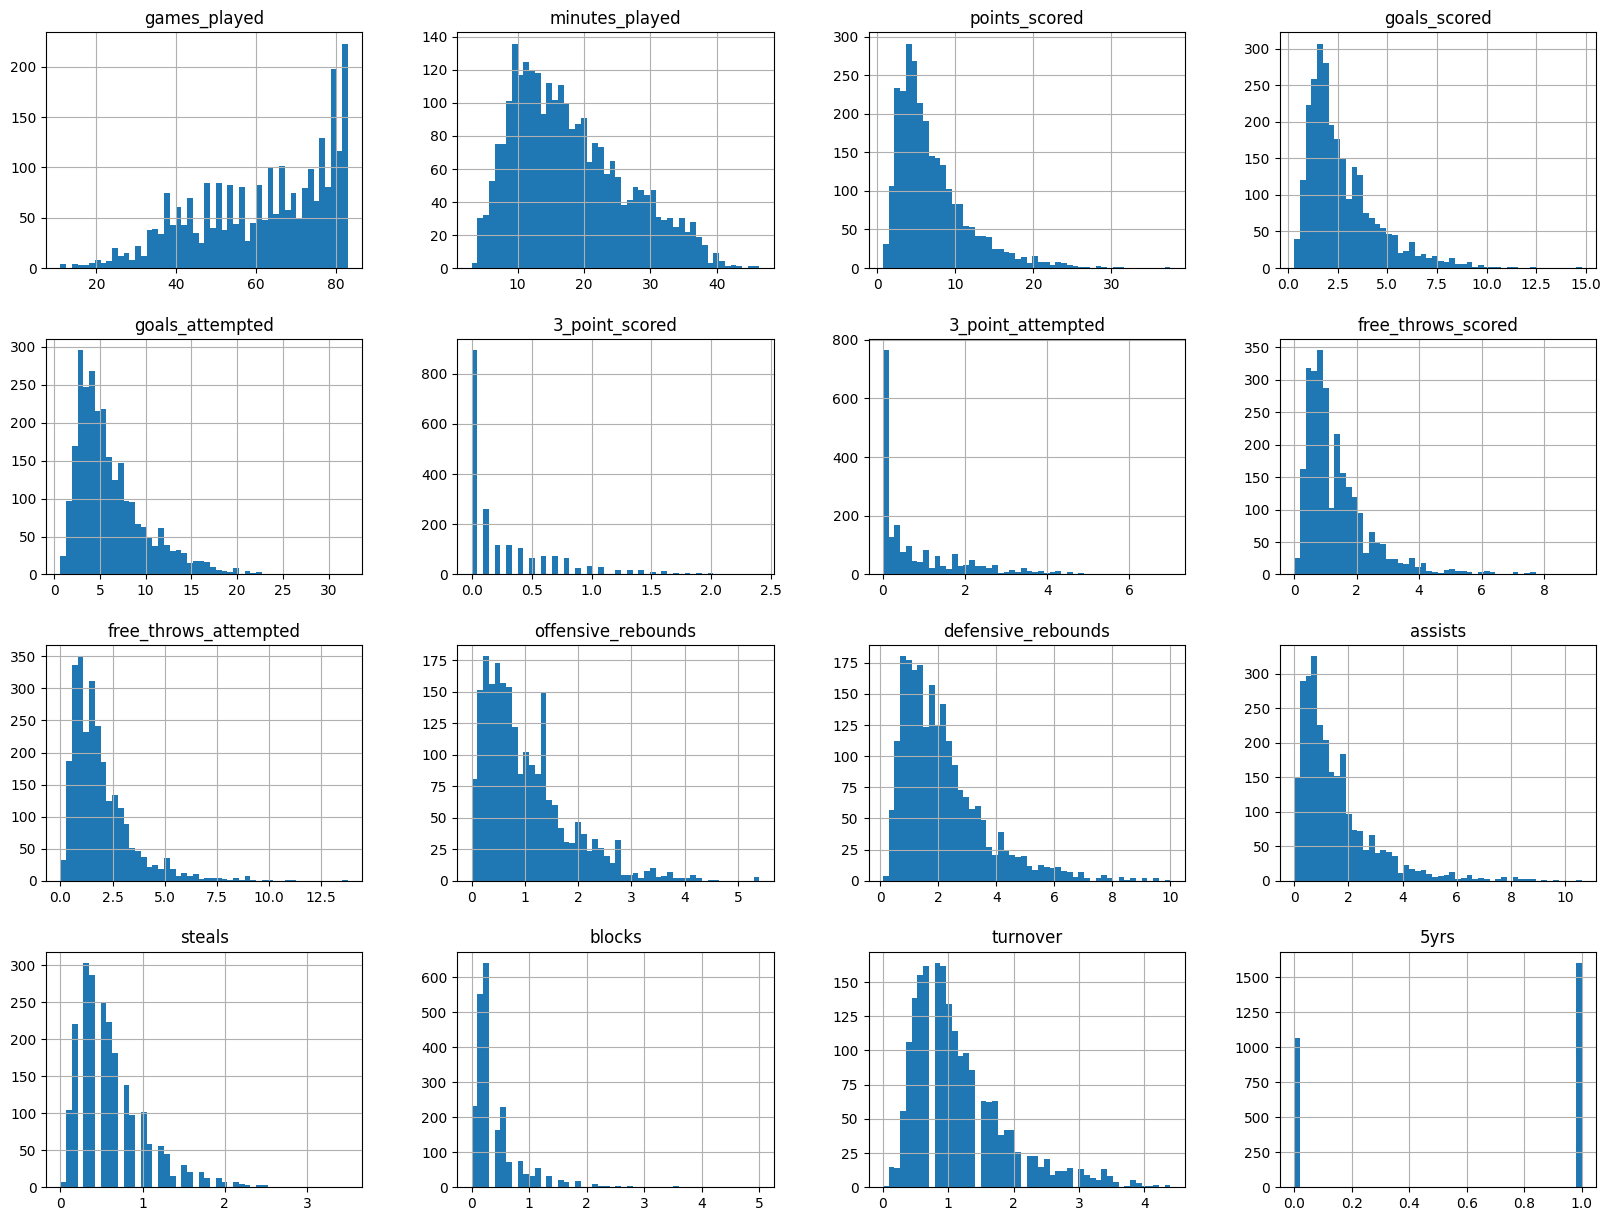

In [10]:
# Historgrams of columns

# Different features are on very different scales
# Most features are tail heavy
# Will need to stratify the train test split on 5yrs as that class is imbalanced

nba.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
# Replace NaN values with 0 # particularly impacts offensive/defensive rebounds, 3 point scored/attempt, turnover by adding a spike at 0
nba.fillna(0, inplace=True)

In [12]:
# Check for duplicate rows
duplicate_rows = nba.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

# Check if all rows are unique
if num_duplicates == 0:
    print("All rows are unique.")
else:
    print(f"There are {num_duplicates} duplicate rows.")

All rows are unique!


In [13]:
# Check for duplicate values in the 'name' column
duplicate_names = nba['name'].duplicated()

# Count the number of duplicate names
num_duplicate_names = duplicate_names.sum()

# Check if there are any duplicates
if num_duplicate_names == 0:
    print("All names are unique.")
else:
    print(f"There are {num_duplicate_names} duplicate names.")

There are 312 duplicate names.


In [14]:
# Duplicate name examples, eg: D'Angelo Russell where all his stats are identical but he has one entry with 5yrs=0 and one entry with 5yrs=1

dup_names = nba[nba['name'].duplicated(keep=False)]
dup_names = dup_names.sort_values(by=['name','games_played'])

# Display the DataFrame with duplicate names
print(dup_names[['name','games_played', '5yrs']])

                     name  games_played  5yrs
1238         Aaron Gordon          47.0   0.0
1471         Aaron Gordon          47.0   1.0
161       Adrian Caldwell          51.0   1.0
1888      Adrian Caldwell          51.0   1.0
572        Andre Drummond          60.0   1.0
...                   ...           ...   ...
1424  Willie Cauley-Stein          66.0   1.0
995           Willie Reed          39.0   0.0
1438          Willie Reed          39.0   0.0
1097          Zach LaVine          77.0   0.0
1458          Zach LaVine          77.0   1.0

[611 rows x 3 columns]


In [15]:
# Drop rows where name and games_played are the same

nba = nba.sort_values(by=['name', 'games_played', '5yrs'], ascending=[True, True, False]) # sort to ensure that if 5yrs has different entries, we keep the entry with 1.

nba = nba.drop_duplicates(subset=['name', 'games_played'], keep='first')

print("Number of duplicate rows removed:")
print(original_rows - nba.shape[0])


Number of duplicate rows removed:
274


In [16]:
# Check remaining entries with the same name
dup_names_2 = nba[nba['name'].duplicated(keep=False)]

# Display the DataFrame with duplicate names
dup_names_2

,name,games_played,minutes_played,points_scored,goals_scored,goals_attempted,3_point_scored,3_point_attempted,free_throws_scored,free_throws_attempted,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnover,5yrs
1,Andrew Harrison,35.0,26.9,7.2,2.0,6.7,0.7,2.8,2.6,3.4,0.5,2.0,3.7,1.1,0.5,1.6,0.0
1381,Andrew Harrison,72.0,20.5,5.9,1.6,5.0,0.6,2.2,2.1,2.7,0.3,1.6,2.8,0.7,0.3,1.2,0.0
294,Bob Martin,43.0,6.7,3.4,1.2,3.1,0.1,0.3,1.0,1.5,0.3,0.7,0.8,0.3,0.1,0.8,0.0
295,Bob Martin,53.0,10.1,2.1,0.8,1.7,0.0,0.0,0.6,1.0,0.7,1.5,0.3,0.1,0.6,0.6,0.0
821,Bobby Jones,44.0,7.6,2.5,1.0,2.1,0.0,0.2,0.5,0.9,0.5,0.8,0.4,0.3,0.0,0.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,Semaj Christon,64.0,15.2,2.9,1.2,3.5,0.2,1.0,0.3,0.5,0.3,1.1,2.0,0.4,0.1,0.7,0.0
2100,Sonny Parker,65.0,13.7,5.8,2.4,4.5,0.0,0.0,1.1,1.4,1.3,1.4,0.9,0.8,0.4,0.0,1.0
966,Sonny Parker,77.0,29.4,9.2,3.5,8.3,0.8,2.5,1.4,2.1,0.4,2.1,4.3,1.2,0.1,2.0,1.0
211,Troy Williams,24.0,17.4,5.3,2.1,5.1,0.4,1.7,0.6,1.0,0.3,1.6,0.8,1.0,0.4,1.1,0.0


**Train-Test split**

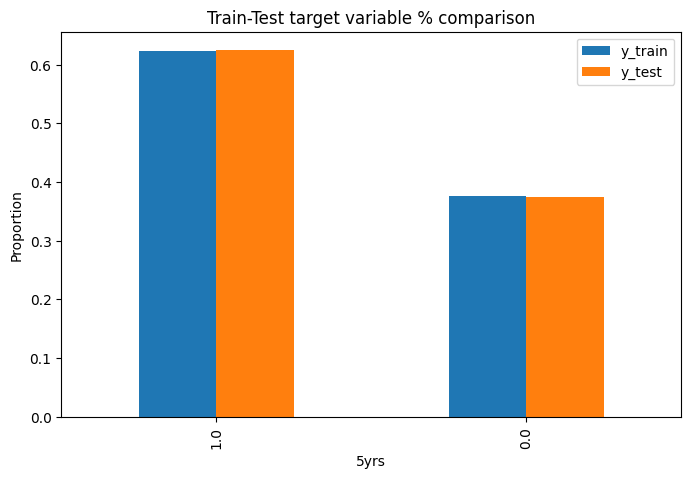

In [17]:
# Train-test split
# stratified on y because we have 40% 0 and 60% 1
x = nba.drop(columns=['name', '5yrs'])
y = nba['5yrs']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Check same proportions of 0s/1s in train and test
proportion_df = pd.DataFrame({
    'y_train': y_train.value_counts(normalize=True),
    'y_test': y_test.value_counts(normalize=True)
})

# Plot the proportions
proportion_df.plot(kind='bar', figsize=(8, 5))
plt.title('Train-Test target variable % comparison')
plt.ylabel('Proportion')
plt.show()

**FEATURE ENGINEERING AND SCALING**

In [18]:
# Feature engineering

# ratios of scored and attempted

x_train["goal_sr"] = x_train["goals_scored"]/x_train["goals_attempted"]
x_train["3_point_sr"] = x_train["3_point_scored"]/x_train["3_point_attempted"]
x_train["free_throws_sr"] = x_train["free_throws_scored"]/x_train["free_throws_attempted"]

# Print out max and min to check
print("Goal Scoring Rate:")
print(f"Max: {x_train['goal_sr'].max()}")
print(f"Min: {x_train['goal_sr'].min()}")

print("\n3-Point Scoring Rate:")
print(f"Max: {x_train['3_point_sr'].max()}")
print(f"Min: {x_train['3_point_sr'].min()}")

print("\nFree Throws Scoring Rate:")
print(f"Max: {x_train['free_throws_sr'].max()}")
print(f"Min: {x_train['free_throws_sr'].min()}")

# do for test data as well
x_test["goal_sr"] = x_test["goals_scored"]/x_test["goals_attempted"]
x_test["3_point_sr"] = x_test["3_point_scored"]/x_test["3_point_attempted"]
x_test["free_throws_sr"] = x_test["free_throws_scored"]/x_test["free_throws_attempted"]

# Replace NaN values with 0
x_test[["goal_sr", "3_point_sr", "free_throws_sr"]] = x_test[["goal_sr", "3_point_sr", "free_throws_sr"]].fillna(0)
x_train[["goal_sr", "3_point_sr", "free_throws_sr"]] = x_train[["goal_sr", "3_point_sr", "free_throws_sr"]].fillna(0)

Goal Scoring Rate:
Max: 0.7586206896551725
Min: 0.18749999999999997

3-Point Scoring Rate:
Max: 1.0
Min: 0.0

Free Throws Scoring Rate:
Max: 1.0
Min: 0.2


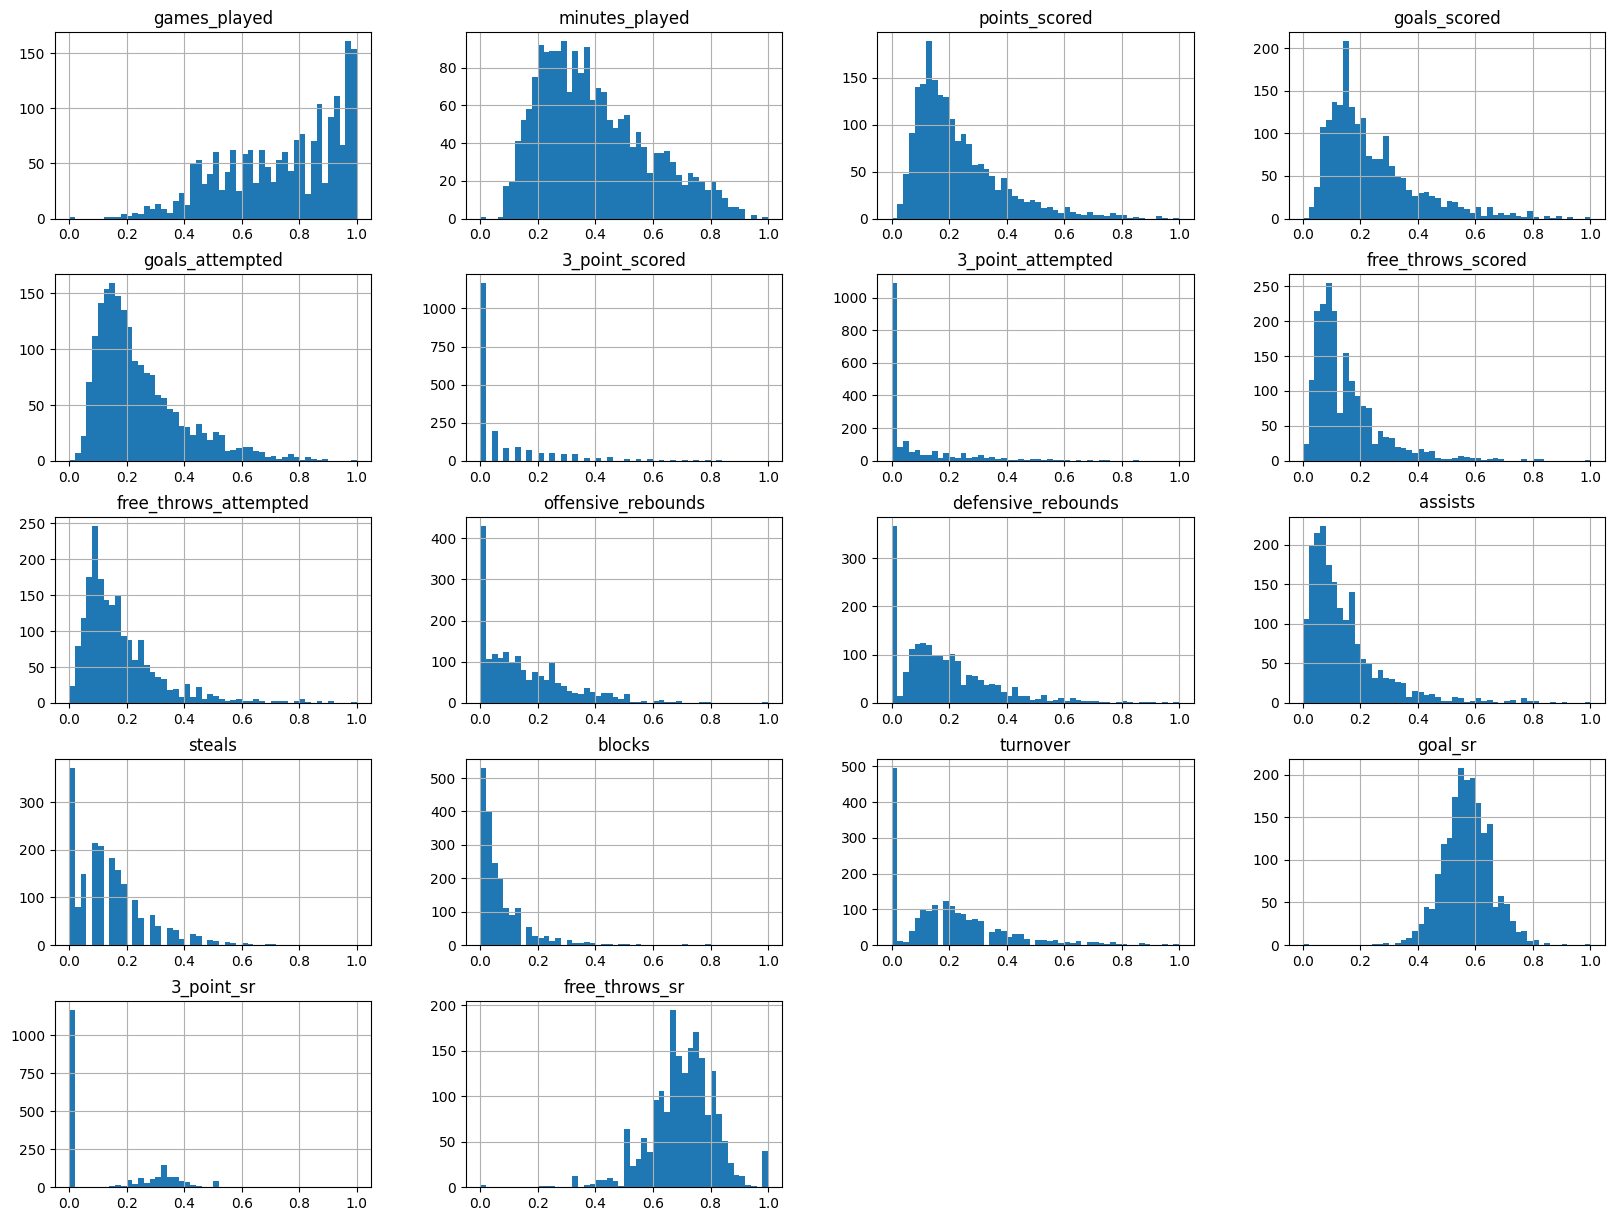

In [19]:
# Scale features - MinMax() because most features do not follow a normal distribution and we don't have outliers

scaler = MinMaxScaler()

# scale train
x_train_arr = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_arr, columns=x_train.columns, index=x_train.index)

# scale test (using scale from x_train)
x_test_arr = scaler.transform(x_test)
x_test = pd.DataFrame(x_test_arr, columns=x_test.columns, index=x_test.index)

x_train.hist(bins=50, figsize=(20,15))
plt.show()

**Feature selection**

In [20]:
# LASSO

L1 = 0.1

reg = LassoCV()
reg.fit(x_train, y_train)
las_predictor_indexes = abs(reg.coef_) > L1

# Print true/false for columns exceeding the threshold
las_predictor_indexes

# Create train/test dfs containing just selected features
x_train_las = x_train.loc[:, las_predictor_indexes]
x_test_las = x_test.loc[:, las_predictor_indexes]

# LASSO coefficients df - for visualisation

# Create a DataFrame with feature names and corresponding coefficients
coefs_las = pd.DataFrame({'feature': x_train.columns, 'coef': reg.coef_})

coefs_las.sort_values(by='coef', ascending=True, inplace=True)

# Show log Lambda (penalty)
log_lmbd = np.log(reg.alpha_)

In [21]:
# Correlation

# 0.25 returns 12/18 features
cor_thr = 0.2

# Create df
df = pd.concat([x_train, y_train], axis=1)

# Calculate correlation
corr = df.loc[:, x_train.columns.tolist() + [y_train.name]].corr()
cor_target = abs(corr[y_train.name])
cor_predictor_indexes = cor_target>cor_thr

# Create train/test dfs containing just selected features
x_train_cor = x_train.loc[:, cor_predictor_indexes]
x_test_cor = x_test.loc[:, cor_predictor_indexes]

In [22]:
# Correlation with target

# Get the feature names from x_train_las
feature_names = x_train_las.columns.tolist()

# Filter cor_target to only include the features from x_train_las
las_cor = cor_target[feature_names]

# Sort the features by their correlation with the target
las_cor_filt = las_cor.sort_values(ascending=False)

# Filter out features with abs(correlation) less than cor_thr
las_cor_filt = las_cor_filt[abs(las_cor_filt) > cor_thr]

las_cor = las_cor.reset_index()
las_cor.columns = ['feature', 'cor']
las_cor.sort_values(by='cor', ascending=True, inplace = True)
las_cor_annt = las_cor.sort_values(by='cor', ascending=False, inplace = False)
las_cor_annt = las_cor_annt[abs(las_cor_annt['cor']) > cor_thr]

print(f"Minimum correlation value: {las_cor_filt.min()}")

Minimum correlation value: 0.23866940108352366


In [23]:
# Correlation amongst the features

cor_feat_thr = 0.52

# Correlation matrix
cor_matrix_las = x_train_las.corr()

min_corr_las = cor_matrix_las.min().min()

# Reorder rows and columns of cor_matrix_las to match the sorted order of features in las_cor_filt
cor_matrix_sorted_las = cor_matrix_las.loc[las_cor_filt.index, las_cor_filt.index]

# Create half matrix for heatmap plot
# Get the mask for the upper triangle (excluding the diagonal)
mask = np.triu(np.ones(cor_matrix_sorted_las.shape), k=1)

# Set upper triangle values to NaN using np.where
cor_matrix_tri = pd.DataFrame(np.where(mask, np.nan, cor_matrix_sorted_las),
                               index=cor_matrix_sorted_las.index,
                               columns=cor_matrix_sorted_las.columns)

# Prepare the text to display on the heatmap cells
heatmap_text = cor_matrix_tri.values  # Get correlation values
heatmap_text = np.round(heatmap_text, 2)  # Format the values to 2 decimal places
heatmap_text = heatmap_text.astype(str)  # Convert the numerical values to string

# 'Remove' values that shouldn't be displayed on the chart
heatmap_text[np.isnan(cor_matrix_tri.values)] = ""
heatmap_text[abs(cor_matrix_tri.values)<cor_feat_thr] = ""
heatmap_text[abs(cor_matrix_tri.values)==1] = ""

heatmap_text

# Check the result
cor_matrix_sorted_las

,games_played,minutes_played,points_scored,offensive_rebounds,turnover,goal_sr,blocks
games_played,1.000000,0.618213,0.548918,0.314743,0.286532,0.272529,0.226333
minutes_played,0.618213,1.000000,0.898668,0.422089,0.476815,0.218315,0.327866
points_scored,0.548918,0.898668,1.000000,0.417920,0.475137,0.269645,0.311142
offensive_rebounds,0.314743,0.422089,0.417920,1.000000,0.502098,0.519566,0.708061
turnover,0.286532,0.476815,0.475137,0.502098,1.000000,0.234590,0.390880
goal_sr,0.272529,0.218315,0.269645,0.519566,0.234590,1.000000,0.397882
blocks,0.226333,0.327866,0.311142,0.708061,0.390880,0.397882,1.000000


In [24]:
# Correlated features, uncorrelated to others

x_train_bf = x_train[['games_played', 'offensive_rebounds', 'turnover', 'goal_sr']]
x_test_bf = x_test[['games_played', 'offensive_rebounds', 'turnover', 'goal_sr']]
final_feat = ['games_played', 'offensive_rebounds', 'turnover', 'goal_sr']

In [25]:
# Feature selection figure

# Create 3 subplots under each other
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        f"<b>Step 1</b> - LASSO selection of features at the optimal penalty of {log_lmbd:.2f}.",
        f"<b>Step 2</b> - Remove features weakly correlated with the target variable.",
        f"<b>Step 3</b> - Remove features correlated with other features."),
    shared_xaxes=False, shared_yaxes=False
)

# =============================
# Colour variables
# =============================

# Define number of features in different categories
all_feat_las = coefs_las.shape[0]
exc_feat_las = coefs_las[abs(coefs_las['coef']) < L1].shape[0]
all_feat_cor = las_cor.shape[0]
exc_feat_cor = las_cor[abs(las_cor['cor']) < cor_thr].shape[0]

# Define bar colours
c_las = ['palegreen',] * all_feat_las
c_las[0:exc_feat_las] = ['crimson',] * exc_feat_las
c_cor = ['palegreen',] * all_feat_cor
c_cor[0:exc_feat_cor] = ['crimson',] * exc_feat_cor

# =============================
# Bars / Traces
# =============================

# Add bars / traces
# LASSO
fig.add_trace(go.Bar(x=coefs_las["feature"], y=coefs_las["coef"], name="Lasso coefficient", marker_color=c_las), row=1, col=1)
# Correlation
fig.add_trace(go.Bar(x=las_cor["feature"], y=las_cor["cor"], name="Correlation (r-value)", marker_color=c_cor), row=2, col=1)
# Correltaion with other features
fig.add_trace(go.Heatmap(z=cor_matrix_tri.values, x=cor_matrix_tri.columns.tolist(),y=cor_matrix_tri.columns.tolist(),
                         colorscale='Picnic',zmin=0,zmax=1,colorbar=dict(title="Correlation", thickness=10,lenmode='fraction', len=0.3, yanchor='bottom', y=0, tickvals=[0, 0.5, 1], ticktext=['0', '0.5', '1'])
                         ,text=heatmap_text,hoverongaps=False, texttemplate="%{text}", textfont=dict(size=10,color="black")), row=3, col=1)

# =============================
# Annotations and lines
# =============================

# Add lines
l1_thrs = 8.5
cor_thrs = 1.5

# L1 threshold
fig.add_vline(x=l1_thrs, line=dict(color="red", width=2, dash="dot"),
              annotation=dict(text=f"Threshold: {L1}", showarrow=False, x=l1_thrs-2.9, yshift=0, font=dict(color="red", size=12)), row=1, col=1)
# Correlation threshold
fig.add_vline(x=cor_thrs, line=dict(color="red", width=2, dash="dot"),
              annotation=dict(text=f"Threshold: {cor_thr}", showarrow=False, x=cor_thrs-1.5, yshift=0, font=dict(color="red", size=12)), row=2, col=1)
# games_played correlates
fig.add_shape(type="rect", x0=-0.51, x1=0.5, y0=1.5, y1=0.5, line=dict(color="red", width=2, dash="dot"), row=3, col=1)
fig.add_shape(type="rect", x0=-0.51, x1=1.5, y0=2.5, y1=1.5, line=dict(color="red", width=2, dash="dot"), row=3, col=1)
# offensive rebounds correlates
fig.add_shape(type="rect", x0=-0.51, x1=5.5, y0=6.5, y1=5.5, line=dict(color="red", width=2, dash="dot"), row=3, col=1)

# Add annotations
# Bullet point list of features
retained_feat_las = "<br>".join([f"• {feat}" for feat in feature_names])
retained_feat_cor = "<br>".join([f"• {feat}" for feat in las_cor_annt['feature']])
final_features = "<br>".join([f"• {feat}" for feat in final_feat])

# Lasso
fig.add_annotation(x=1.15, y=1, xref="paper", yref="paper",
    text=f"<b>Retained features after<br>LASSO selection:</b><br>{retained_feat_las}",
    showarrow=False, align="left", font=dict(size=12, color="black"), xanchor="left", yanchor="top")
# Correlation
fig.add_annotation(x=1.15, y=0.62, xref="paper", yref="paper",
    text=f"<b>Retained features after<br>correlation selection:</b><br>{retained_feat_cor}",
    showarrow=False, align="left", font=dict(size=12, color="black"), xanchor="left", yanchor="top")
# Final features
fig.add_annotation(x=1.15, y=0.22, xref="paper", yref="paper",
    text=f"<b>Final features:</b><br>{final_features}",
    showarrow=False, align="left", font=dict(size=12, color="black"), xanchor="left", yanchor="top")
fig.add_annotation(x=0.65, y=0.18, xref="paper", yref="paper",
                   text="Threshold: r > 0.52",
                   showarrow=False, align="left", font=dict(size=12, color="red"), xanchor="left", yanchor="top")

# =============================
# Final Layout Adjustments
# =============================

# Update layout
fig.update_layout(
    showlegend=False,
    width=1000, height=1000,
    template='plotly_white',
    title_text="<b>Feature selection</b>",
    font=dict(size=12),
    yaxis1=dict(title="Coefficient", tickvals=[0.1,0.2,0.3,0.4,0.5,0.6],ticktext=["0.1","0.2","0.3","0.4","0.5","0.6"]),
    yaxis2=dict(title="Correlation coefficient (r)"),
    yaxis3=dict(title="Feature", autorange="reversed", showgrid=False),
    xaxis3=dict(title="Feature", showgrid=False),
    margin=dict(l=50, r=250, t=80, b=50)
)

fig.layout.annotations[0].update(text=f"<b>Step 1</b> - LASSO selection of features at the optimal penalty of {log_lmbd:.2f}.", font=dict(size=14, color="black"), align="left")
fig.layout.annotations[1].update(text=f"<b>Step 2</b> - Remove features weakly correlated with the target variable.", font=dict(size=14, color="black"), align="left")
fig.layout.annotations[2].update(text=f"<b>Step 3</b> - Remove features correlated with other features.", font=dict(size=14, color="black"), align="left")

# Show figure
fig.show()


**MODEL TRAINING**

**Model 1 - Linear regression - 'games_played' only**

In [26]:
# Linear regression model - games_played only

# R-squared = 0.147 train; test - 0.112

# Fit
lr = LinearRegression().fit(x_train[['games_played']], y_train)

# Predict
lr_pred = lr.predict(x_train[['games_played']])

# Train performance
lr_r2 = r2_score(y_train, lr_pred)
lr_mse = mean_squared_error(y_train, lr_pred)

print(f"R-squared: {lr_r2}")
print(f"Mean Squared Error: {lr_mse}")

R-squared: 0.14705323697219486
Mean Squared Error: 0.2001032465396229


**Model 2 - logistic regression - all features**

In [27]:
# Logistic regression model - all features

log_all = LogisticRegression().fit(x_train, y_train)

# Train accuracy
log_all_pred = log_all.predict(x_train)
log_all_acc = accuracy_score(y_train, log_all_pred)

# Test accuracy
# log_all_pred = log_all.predict(x_test)
# log_all_acc = accuracy_score(y_test, log_all_pred)

print(f"Accuracy: {log_all_acc}")

Accuracy: 0.7247132429614181


**Model 3 - logistic regression - selected features**

In [28]:
# Logistic regression model on my chosen features

bf_model = LogisticRegression().fit(x_train_bf, y_train)
y_pred = bf_model.predict(x_train_bf)
bf_train_acc = accuracy_score(y_train, y_pred)

print(f"Logistic Regression: Cor thr {cor_thr}, LASSO thr {L1}: {bf_train_acc}") # 0.714 correlation 0.2 (+no correlated to eachother >=0.52), L1-0.1 - LASSO on its own, equal to correlation

Logistic Regression: Cor thr 0.2, LASSO thr 0.1: 0.713764337851929


**Model 4 - random forest - selected features**

In [46]:
# Random Forest Regression model on chosen features
# Regularized using a small grid search and on oob_score_ to find optimal hyperparameters

# with no regularization, r-squared=0.87 BUT oob r-squared = 0.115 (worse than linear regression) - see code in appendix

# Define parameters and values to grid search on
param_grid = {
    'min_samples_leaf': [None, 5, 10],  # None equivalent to 1 (default)
    'max_depth': [None, 5, 10, 20]         # None for no constraint
}

# Variables to store the best model and highest OOB score
best_oob_score = -np.inf  # Initialize to a very low value
best_params = None
best_rf = None

# Perform Grid Search
for min_samples_leaf in param_grid['min_samples_leaf']:
    for max_depth in param_grid['max_depth']:
        # Define and fit the model with current parameters
        rf = RandomForestRegressor(
            oob_score=True,
            min_samples_leaf=min_samples_leaf if min_samples_leaf else 1,
            max_depth=max_depth,
            random_state=42
        )

        # Fit the model on training data
        rf.fit(x_train_bf, y_train)

        # Calculate OOB score
        oob_score = rf.oob_score_

        # Update best model if this is the highest OOB score
        if oob_score > best_oob_score:
            best_oob_score = oob_score
            best_params = {'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}
            best_rf = rf

# Predict using best model
y_pred_rf = best_rf.predict(x_train_bf)

# Calculate results for best model
rf_r2 = r2_score(y_train, y_pred_rf)
rf_mse = mean_squared_error(y_train, y_pred_rf)

# Random Forest results
print("Random Forest (Best Model)")
print(f"Best Parameters: {best_params}")
print(f"R-squared: {rf_r2:.4f}")
print(f"OOB Score: {best_oob_score:.4f}") # overfitted but still better than linear regression
print(f"Mean Squared Error: {rf_mse:.4f}")

Random Forest (Best Model)
Best Parameters: {'min_samples_leaf': 5, 'max_depth': 5}
R-squared: 0.3021
OOB Score: 0.2104
Mean Squared Error: 0.1637


**Setting precision-recall threshold**

Max F1 score used to determine optimal threshold

In [30]:
# Model names
# lr, log_all, bf_model, bf_rf

In [31]:
# Define function to calculate log of regression outputs

def _log(mod, x):
    pred = mod.predict(x)
    prob = 1/(1+np.exp(-pred))

    return prob

In [32]:
# Train set predictions

# Linear Regression - games_played
pred_lr = _log(lr, x_train[['games_played']])

# Logistic Regression - all features
pred_log_all = log_all.predict_proba(x_train)

# Logistic Regression - best features
pred_log_bf = bf_model.predict_proba(x_train_bf)

# RandomForest
pred_rf = _log(best_rf, x_train_bf)

In [33]:
# Custom precision-recall function '_PR'

def _PR(y, pred_prob):
    '''
    Description: calculates the precision, recall, accuracy, and F1 score at different probability thresholds for any binary classifier.

    Inputs:
    1. y: 1D array containing actual class label (0,1) for each sample.
    2. pred_prob: 1D array containing prediction probability for the postive class (1) for each sample. Must be same length as y.

    Outputs: df containing 5 columns
    1. thrs: the probability thresholds used for determining the prediction result. The sorted, unique, values of pred_prob.
    2. prec: the precision values at each threshold.
    3. recall: the recall values at each threshold.
    4. accuracy: the accuracy values at each threshold.
    5. f1: the F1 score values at each threshold.
    '''
    # Create thrs: sorted unique values of pred_prob
    thrs = np.sort(np.unique(pred_prob))[::-1]

    # Create lists to store output values
    prec_list = []
    recall_list = []
    accuracy_list = []
    f1_list = []

    # Loop through each threshold
    for i in thrs:

        # Calculate predicted class labels for current threshold
        y_pred = np.where(pred_prob >= i, 1, 0)

        # Calculate TP, FP, FN, TN
        TP = np.sum((y_pred == 1) & (y == 1))  # True Positives
        FP = np.sum((y_pred == 1) & (y == 0))  # False Positives
        FN = np.sum((y_pred == 0) & (y == 1))  # False Negatives
        TN = np.sum((y_pred == 0) & (y == 0))  # True Negatives

        # Calculate metrics
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        accuracy = TP + TN / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0.0
        f1 = TP / (TP + (FN+FP)/2) if TP + (FN+FP)/2 > 0 else 0.0

        # Append metric values to a list
        prec_list.append(prec)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        f1_list.append(f1)

    # Create output df
    outputs = pd.DataFrame({
        'thrs': thrs,
        'prec': prec_list,
        'recall': recall_list,
        'accuracy': accuracy_list,
        'f1': f1_list
    })

    return outputs

In [34]:
# Precision-Recall of each model - train

# lr
lr_pr = _PR(y_train, pred_lr)

# log_all
log_all_pr = _PR(y_train, pred_log_all[:,1]) # probability sample belongs to class 1

# log_bf
log_bf_pr = _PR(y_train, pred_log_bf[:,1]) # probability sample belongs to class 1

# bf_rf
bf_rf_pr = _PR(y_train, pred_rf)

In [35]:
# Calculate optimum prediction threshold (maximising F1 score) - train

# For each model, calculate the max F1 score, the threshold, precision, and recall at that score

# lr - train
threshold1 = lr_pr.loc[lr_pr['f1'].idxmax(), 'thrs']
precision1 = lr_pr.loc[lr_pr['f1'].idxmax(), 'prec']
recall1 = lr_pr.loc[lr_pr['f1'].idxmax(), 'recall']

# log_all - train
threshold2 = log_all_pr.loc[log_all_pr['f1'].idxmax(), 'thrs']
precision2 = log_all_pr.loc[log_all_pr['f1'].idxmax(), 'prec']
recall2 = log_all_pr.loc[log_all_pr['f1'].idxmax(), 'recall']

# log_bf - train
threshold3 = log_bf_pr.loc[log_bf_pr['f1'].idxmax(), 'thrs']
precision3 = log_bf_pr.loc[log_bf_pr['f1'].idxmax(), 'prec']
recall3 = log_bf_pr.loc[log_bf_pr['f1'].idxmax(), 'recall']

# bf_rf - train
threshold4 = bf_rf_pr.loc[bf_rf_pr['f1'].idxmax(), 'thrs']
precision4 = bf_rf_pr.loc[bf_rf_pr['f1'].idxmax(), 'prec']
recall4 = bf_rf_pr.loc[bf_rf_pr['f1'].idxmax(), 'recall']

*Plotting*

In [36]:
# Function to add line traces and max F1 markers
def add_trace_pr(df, name, l_colour, m_colour):
    # Add the PR curve
    fig.add_trace(go.Scatter(
        x=df['recall'],
        y=df['prec'],
        mode='lines',
        name=name,
        line=dict(color=l_colour),
        hovertemplate="<b>Recall:</b> %{x:.2%}<br>" +"<b>Precision:</b> %{y:.2%}<br>" +"<b>F1 Score:</b> %{text:.2%}",
        text=df['f1']
    ))

    # Find max F1 score
    max_f1_index = df['f1'].idxmax()
    max_recall = df['recall'][max_f1_index]
    max_prec = df['prec'][max_f1_index]
    max_f1 = df['f1'][max_f1_index]
    max_thrs = df['thrs'][max_f1_index]

    # Create text for the marker
    m_text = f"Threshold: {max_thrs:.2%}<br>F1 Score: {max_f1:.2%}"

    # Add a marker at the max F1 point
    fig.add_trace(go.Scatter(
        x=[max_recall],
        y=[max_prec],
        mode='markers',
        marker=dict(
            color=m_colour,
            size=10,
            symbol='circle',
        ),
        name=f"Max F1: {name}",
        hovertemplate="<b>Max F1 Point</b><br>" +
                      f"<b>{m_text}</b><br>" +
                      "<b>Recall:</b> %{x:.2%}<br>" +
                      "<b>Precision:</b> %{y:.2%}",
        text=[m_text]
    ))

In [37]:
# Plot precision-recall results - train

fig = go.Figure()
fig.update_layout(showlegend=True,
                  width=1000,
                  height=600,
                  title='<b>Pecision-Recall curves for train set predictions</b><br>Threshold = maximum F1 score',
                  template='plotly_white',
                  xaxis_title="Recall",
                  yaxis_title="Precision")

# Add traces
add_trace_pr(lr_pr, "Linear - games_played", "rgba(0, 0, 255, 0.5)", "blue")
add_trace_pr(log_all_pr, "Logistic - all", "rgba(255, 0, 0, 0.5)", "red")
add_trace_pr(log_bf_pr, "Logistic - select", "rgba(0, 255, 0, 0.5)", "green")
add_trace_pr(bf_rf_pr, "Random Forest - select", "rgba(128, 0, 128, 0.5)", "purple")

# Set axis range
fig.update_layout(yaxis_range=[0.6, 1.04], xaxis_range=[0, 1.04])
fig.show()

**Measuring model performance on test set**

In [38]:
# Test set probability level predictions

#Linear Regression - games_played
pred_lr_ts = _log(lr, x_test[['games_played']])

# Logistic Regression - all features
pred_log_all_ts = log_all.predict_proba(x_test) # returns probability of y=0, probability of y=1

# Logistic Regression - best features
pred_log_bf_ts = bf_model.predict_proba(x_test_bf) # returns probability of y=0, probability of y=1

#RandomForest
pred_rf_ts = _log(best_rf, x_test_bf)

In [39]:
# Generate precision-recall-accuracy-f1 results at each threshold - test

# lr
lr_pr_ts = _PR(y_test, pred_lr_ts)

# log_all
log_all_pr_ts = _PR(y_test, pred_log_all_ts[:,1]) # probability sample belongs to class 1

# log_bf
log_bf_pr_ts = _PR(y_test, pred_log_bf_ts[:,1]) # probability sample belongs to class 1

# rf
rf_pr_ts = _PR(y_test, pred_rf_ts)

In [40]:
# Calculate optimum prediction threshold (maximising F1 score) - test

# For each model, calculate the max F1 score, the threshold, precision, and recall at that score

# lr - test
threshold1_ts = lr_pr_ts.loc[lr_pr_ts['f1'].idxmax(), 'thrs']
precision1_ts = lr_pr_ts.loc[lr_pr_ts['f1'].idxmax(), 'prec']
recall1_ts = lr_pr_ts.loc[lr_pr_ts['f1'].idxmax(), 'recall']

# log_all - train
threshold2_ts = log_all_pr_ts.loc[log_all_pr_ts['f1'].idxmax(), 'thrs']
precision2_ts = log_all_pr_ts.loc[log_all_pr_ts['f1'].idxmax(), 'prec']
recall2_ts = log_all_pr_ts.loc[log_all_pr_ts['f1'].idxmax(), 'recall']

# log_bf - train
threshold3_ts = log_bf_pr_ts.loc[log_bf_pr_ts['f1'].idxmax(), 'thrs']
precision3_ts = log_bf_pr_ts.loc[log_bf_pr_ts['f1'].idxmax(), 'prec']
recall3_ts = log_bf_pr_ts.loc[log_bf_pr_ts['f1'].idxmax(), 'recall']

# bf_rf - train
threshold4_ts = rf_pr_ts.loc[rf_pr_ts['f1'].idxmax(), 'thrs']
precision4_ts = rf_pr_ts.loc[rf_pr_ts['f1'].idxmax(), 'prec']
recall4_ts = rf_pr_ts.loc[rf_pr_ts['f1'].idxmax(), 'recall']

*Plotting*

In [41]:
# Plot precision-recall results - test

fig = go.Figure()
fig.update_layout(showlegend=True,
                  width=1000,
                  height=600,
                  title='<b>Pecision-Recall curves for test set predictions</b><br>Threshold = maximum F1 score',
                  template='plotly_white',
                  xaxis_title="Recall",
                  yaxis_title="Precision")

# Add traces
add_trace_pr(lr_pr_ts, "Linear - games_played", "rgba(0, 0, 255, 0.5)", "blue")
add_trace_pr(log_all_pr_ts, "Logistic - all", "rgba(255, 0, 0, 0.5)", "red")
add_trace_pr(log_bf_pr_ts, "Logistic - select", "rgba(0, 255, 0, 0.5)", "green")
add_trace_pr(rf_pr_ts, "Random Forest - select", "rgba(128, 0, 128, 0.5)", "purple")

# Set axis range
fig.update_layout(yaxis_range=[0.6, 1.04], xaxis_range=[0, 1.04])
fig.show()

In [42]:
# Generate a prediction at the F1 max threshold value for test set

#lr
lr_y_pred = (pred_lr_ts >= threshold1).astype(int) # 0 or 1 prediction array at optimum threshold

#log_all
log_all_y_pred = (pred_log_all_ts[:,1] >= threshold2).astype(int)

#log_bf
log_bf_y_pred = (pred_log_bf_ts[:,1] >= threshold3).astype(int)

#rf
rf_y_pred = (pred_rf_ts >= threshold4).astype(int)


In [43]:
# % accuracy and Precision-Recall AUC of each model

# lr - test
acc_ts1 = accuracy_score(y_test, lr_y_pred)
pr_auc_ts1 = auc(lr_pr_ts['recall'], lr_pr_ts['prec'])

# log_all - test
acc_ts2 = accuracy_score(y_test, log_all_y_pred)
pr_auc_ts2 = auc(log_all_pr_ts['recall'], log_all_pr_ts['prec'])

# log_bf - test
acc_ts3 = accuracy_score(y_test, log_bf_y_pred)
pr_auc_ts3 = auc(log_bf_pr_ts['recall'], log_bf_pr_ts['prec'])

# # bf_rf - train
acc_ts4 = accuracy_score(y_test, rf_y_pred)
pr_auc_ts4 = auc(rf_pr_ts['recall'], rf_pr_ts['prec'])

In [44]:
# df containing accuracy and Precision-Recall AUC of each model

# Create dictionary
results_dict = {
    'model_name': ['linear', 'log_all', 'log_bf', 'randomforest_bf'],
    'accuracy': [acc_ts1, acc_ts2, acc_ts3, acc_ts4],
    'auc': [pr_auc_ts1, pr_auc_ts2, pr_auc_ts3, pr_auc_ts4]
}

# Convert to df
test_results = pd.DataFrame(results_dict)

# Print the results
print(test_results)


        model_name  accuracy       auc
0           linear  0.672917  0.675667
1          log_all  0.693750  0.852355
2           log_bf  0.695833  0.842484
3  randomforest_bf  0.725000  0.827932


**Appendix**

In [45]:
# # Random Forest regressor - my features
# # Regularization needed. Use grid search to determine best hyperparamters and reduce overfitting:
#     # max_depth
#     # min_samples_leaf
#     # oob_score used to estimate generalisability
# # Random Forest regressor is significantly better than Linear Regression on games_played only

# bf_rf = RandomForestRegressor(oob_score = True).fit(x_train_bf, y_train)
# y_pred_rf = bf_rf.predict(x_train_bf)

# rf_r2 = r2_score(y_train, y_pred_rf)
# rf_mse = mean_squared_error(y_train, y_pred_rf)

# print("Random Forest")
# print(f"R-squared: {rf_r2}")
# print("OOB Score:", bf_rf.oob_score_) # with no regularization, r-squared=0.87 BUT oob r-squared = 0.115 (worse than linear regression)
# print(f"Mean Squared Error: {rf_mse}")